In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import json
import cv2
import os
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [4]:
# set data directory
dataDir = '../dataset/' 
dataType = 'train.json'
annFile = dataDir + dataType

In [5]:
# initialize COCO api for instance annotations
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [17]:
# implement Data frame
df = pd.DataFrame()
df['id'] = coco.getAnnIds()

ls=[]
for i in range(len(coco.getAnnIds())):
    ls +=[int(coco.loadAnns(i)[0]['image_id'])]
df['image_id'] = ls

ls=[]
for i in range(len(coco.getAnnIds())):
    ls +=[int(coco.loadAnns(i)[0]['category_id'])]
df['category_id'] = ls

ls=[]
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
for i in range(len(coco.getAnnIds())):
    ls += [nms[int(coco.loadAnns(i)[0]['category_id'])]]
df['category_name'] = ls

ls=[]
for i in range(len(coco.getAnnIds())):
    ls += [(coco.loadAnns(i)[0]['area'])]
df['area'] = ls

df['sqrt_area'] = [np.sqrt(x) for x in df['area']]

ls=[]
for i in range(len(coco.getAnnIds())):
    ls += [float(coco.loadAnns(i)[0]['bbox'][0])]
df['x'] = ls

ls=[]
for i in range(len(coco.getAnnIds())):
    ls += [float(coco.loadAnns(i)[0]['bbox'][1])]
df['y'] = ls

ls=[]
for i in range(len(coco.getAnnIds())):
    ls += [float(coco.loadAnns(i)[0]['bbox'][2])]
df['w'] = ls

ls=[]
for i in range(len(coco.getAnnIds())):
    ls += [float(coco.loadAnns(i)[0]['bbox'][3])]
df['h'] = ls

pd.set_option('float_format', '{:f}'.format)
df.sample(10)

id  image_id  category_id  category_name          area  sqrt_area  \
9634    9634      2007            1          Paper  31665.900000 177.949150   
11283  11283      2390            3          Metal 109969.190000 331.616028   
5672    5672      1176            1          Paper 130279.380000 360.942350   
15406  15406      3243            7    Plastic bag 316199.820000 562.316477   
21303  21303      4492            1          Paper  12103.520000 110.015999   
2198    2198       442            1          Paper   1712.520000  41.382605   
15977  15977      3356            0  General trash   2781.000000  52.735187   
12945  12945      2743            7    Plastic bag  82267.080000 286.822384   
3569    3569       761            1          Paper   4390.760000  66.262810   
13950  13950      2956            1          Paper  38270.000000 195.627196   

               x          y          w          h  
9634  580.300000 214.300000 178.500000 177.400000  
11283 409.100000 306.800000 390.100000 281.900000  
5672  117.800000 474.400000 363.300000 358.600000  
15406  59.700000  45.400000 425.400000 743.300000  
21303   0.000000 448.300000 101.200000 119.600000  
2198  290.900000 195.000000  60.300000  28.400000  
15977 183.200000 826.700000  54.000000  51.500000  
12945 614.100000 462.600000 246.900000 333.200000  
3569  625.000000 340.700000  58.700000  74.800000  
13950 660.100000 138.200000 222.500000 172.000000

# 통합적인 정보

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23144 entries, 0 to 23143
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             23144 non-null  int64  
 1   image_id       23144 non-null  int64  
 2   category_id    23144 non-null  int64  
 3   category_name  23144 non-null  object 
 4   area           23144 non-null  float64
 5   sqrt_area      23144 non-null  float64
 6   x              23144 non-null  float64
 7   y              23144 non-null  float64
 8   w              23144 non-null  float64
 9   h              23144 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.8+ MB


In [19]:
df.describe()

id     image_id  category_id           area    sqrt_area  \
count 23144.000000 23144.000000 23144.000000   23144.000000 23144.000000   
mean  11571.500000  2439.377333     3.409307   92863.957838   244.441407   
std    6681.241651  1410.659303     2.834300  135979.147858   181.971941   
min       0.000000     0.000000     0.000000       0.560000     0.748331   
25%    5785.750000  1206.000000     1.000000    9997.670000    99.988349   
50%   11571.500000  2453.500000     3.000000   38938.470000   197.328330   
75%   17357.250000  3678.000000     7.000000  119122.475000   345.141239   
max   23143.000000  4882.000000     9.000000 1048371.210000  1023.900000   

                 x            y            w            h  
count 23144.000000 23144.000000 23144.000000 23144.000000  
mean    386.195653   382.230008   257.499170   252.241518  
std     244.491114   217.282849   204.582362   200.143898  
min       0.000000     0.000000     0.700000     0.800000  
25%     200.100000   226.975000    99.750000    93.500000  
50%     362.700000   370.500000   200.900000   196.100000  
75%     553.325000   524.900000   357.650000   359.825000  
max    1015.400000  1011.500000  1023.900000  1023.900000

In [20]:
n_train_imgs = len(coco.getImgIds())
n_cats = len(coco.getCatIds())
print(f'train 이미지 개수: {n_train_imgs}')
print(f'클래스 개수: {n_cats}')


train 이미지 개수: 4883
클래스 개수: 10


# 클래스 분포 확인

In [21]:
# display COCO categories
print('COCO categories: \n{}\n'.format('\n'.join(nms)))

COCO categories: 
General trash
Paper
Paper pack
Metal
Glass
Plastic
Styrofoam
Plastic bag
Battery
Clothing



In [12]:
# df.to_csv(os.path.join(dataDir,'annotation.csv'))

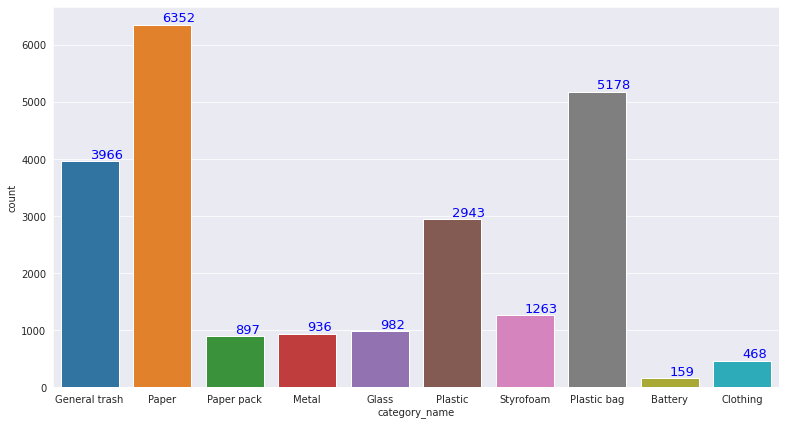

In [52]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(13,7))
s = sns.countplot(x='category_name',data=df,order=nms)
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+p.get_width()*0.5, p.get_height()+50) , color = 'blue', fontsize=13)


# 한 이미지 당 물체 개수

/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


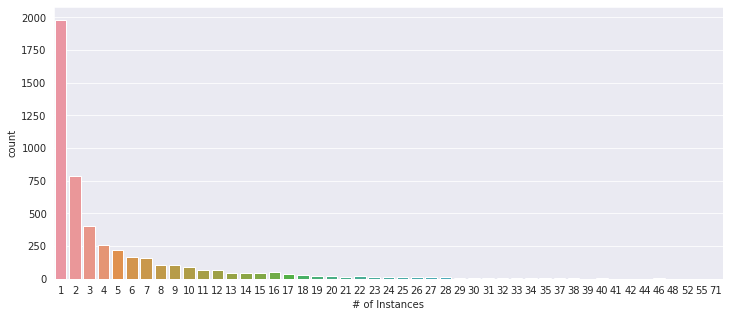

In [63]:
lst = []
for i in range(n_train_imgs):
    lst.append(len(coco.getAnnIds(imgIds=i)))
fig,axes = plt.subplots(1,1,figsize=(12,5))
s = sns.countplot(lst)
plt.xlabel('# of Instances')
plt.show()


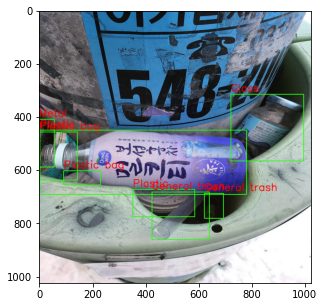

In [51]:
def draw_bboxes(img_id,coco,ax):
    anns = coco.getAnnIds(imgIds=img_id)
    img = cv2.imread(dataDir+coco.loadImgs(img_id)[0]['file_name'])
    for ann in anns:
        x, y, w, h = map(int, coco.loadAnns(ann)[0]['bbox'])
        label = coco.loadCats(coco.loadAnns(ann)[0]['category_id'])[0]['name']
        image = cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 0), 2)
    ax.imshow(image)


fig, axes = plt.subplots(1,1, figsize=(12,5))
draw_bboxes(1, coco, axes)

# 클래스별 객체 크기 비교

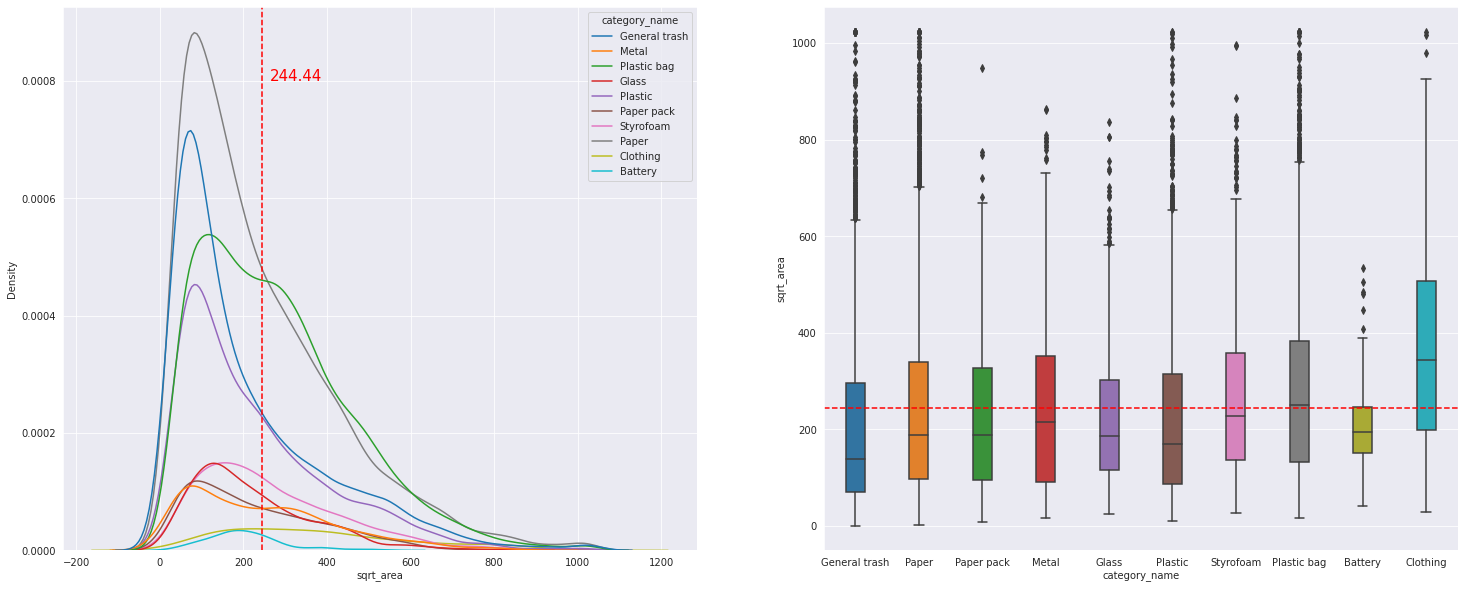

In [66]:
fig, axes = plt.subplots(1,2,figsize=(25,10))
sns.kdeplot(x='sqrt_area',data=df,hue='category_name',ax=axes[0])
axes[0].axvline(x=df['sqrt_area'].mean(),color='r',linestyle='--')
axes[0].text(x=df['sqrt_area'].mean()+20, y=0.0008,s="{:.2f}".format(df['sqrt_area'].mean()),
color='r',fontsize=15)
sns.boxplot(x='category_name',y='sqrt_area',data=df,ax=axes[1],width=0.3,order=nms)
axes[1].axhline(y=df['sqrt_area'].mean(),color='r',linestyle='--')

# w와 h 상관 관계

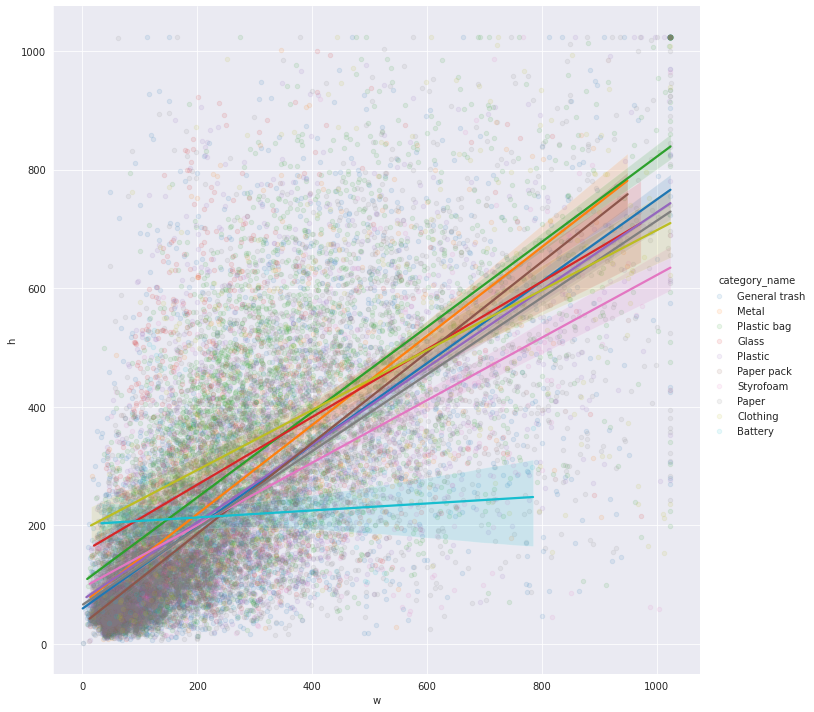

In [64]:
# fig, ax = plt.subplots(figsize=(10,10))
# sns.scatterplot(x='w',y='h',data=df,hue='category_name')
sns.lmplot(x='w',y='h',data=df,hue='category_name',height=10,scatter_kws={'s': 20, 'alpha': 0.1},)
# sns.lineplot(x='w',y='h',data=df,hue='category_name',ax=ax)
# plt.legend(bbox_to_anchor=(1.2, 1.0),loc= 'upper right',borderaxespad=0)
# plt.show()

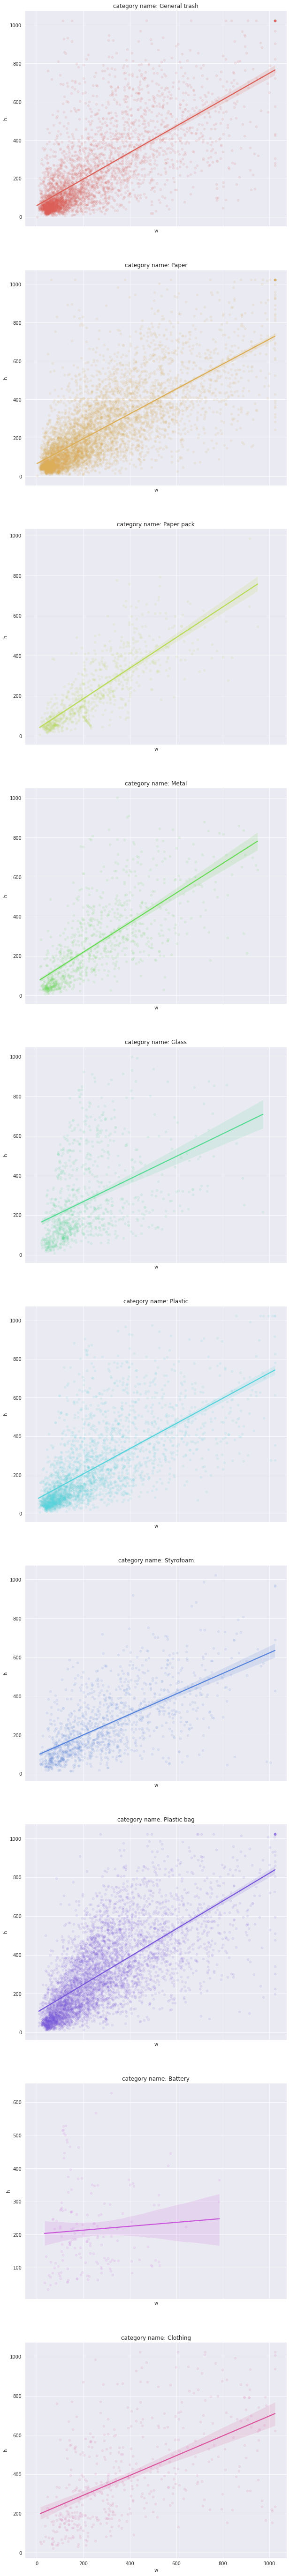

In [65]:
f, axes = plt.subplots(10,sharex=True,figsize=(10,100))
c = sns.color_palette("hls", 10)
for i in range(10):
    p = sns.regplot(x='w',y='h',data=df[df['category_id']==i],scatter_kws={'s': 20, 'alpha': 0.1,'color': c[i]},line_kws={'color': c[i]},ax=axes[i])
    p.set_title(f'category name: {nms[i]}')
plt.show()
# f.savefig("output.png")

